Feature Selection Assistance Found At:

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import scipy as sp
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


ob = pd.read_excel("data/Obesity_Dataset.xlsx")
classifier_names = ['DecisionTreeClassifier', 'SVC', 'RandomForestClassifier', 'GradientBoostingClassifier', 'KNeighborsClassifier']
classifiers = [DecisionTreeClassifier, SVC, RandomForestClassifier, GradientBoostingClassifier, KNeighborsClassifier]
models_dict = {}
RANDOMSTATE = 42

param_grids = {
    'DecisionTreeClassifier': {'max_depth': [i for i in range(1,15)], 
                               'ccp_alpha': [0, .1, .2, .5, 1], 
                               'class_weight': [None, 'balanced'], 
                               'criterion': ['gini', 'entropy', 'log_loss'],
                               'random_state': [RANDOMSTATE]},
    
    'SVC': {'C': [i for i in range(90,101)], 
            'gamma': ['auto', 'scale', .01], 
            'kernel': ['rbf', 'linear', 'sigmoid'], 
            'random_state': [RANDOMSTATE]},
    
    'RandomForestClassifier': {'n_estimators': [i*10 for i in range(5,13)], 
                               'max_depth': [i for i in range(1,15)], 
                               #'ccp_alpha': [0, .1, 1],
                               'criterion': ['gini', 'entropy', 'log_loss'], 
                               'max_features': ['sqrt', 'log2', None], 
                               'random_state': [RANDOMSTATE]},
    
    'GradientBoostingClassifier': {'n_estimators': [i*10 for i in range(1,15)], 
                                   'max_depth': [i for i in range(1,10)], 
                                   #'ccp_alpha': [0, .1, 1], 
                                   'learning_rate': [.001, .01, .1, .4], 
                                   'random_state': [RANDOMSTATE]},
    
    'KNeighborsClassifier': {'n_neighbors': [i for i in range(1,20)], 
                             'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'], 
                             'weights': ['distance', 'uniform'], 
                             'p': [1, 2]}
}

def ParamTournament(x_tr, x_te, y_tr, y_te, params_list, scoring_param='accuracy', clf=DecisionTreeClassifier):
    top = 0, {}
    for params in params_list:
        m = clf(**params).fit(x_tr, y_tr)
        y_hat = m.predict(x_te)
        
        if scoring_param == 'accuracy':
            test_score = accuracy_score(y_true=y_te, y_pred=y_hat)
        
        elif scoring_param == 'balanced_accuracy':
            test_score = balanced_accuracy_score(y_true=y_te, y_pred=y_hat)
        
        elif scoring_param == 'f1_weighted':
            test_score = f1_score(y_true=y_te, y_pred=y_hat, average='weighted')
        
        top = (test_score, params) if test_score > top[0] else (top[0], top[1])

    return top[1] 


def pipe_scores(clf, p_grid, x_tr, x_te, y_tr, y_te, scoring_param='accuracy'):
    '''pipeline for a given format of classifier'''
    
    models = GridSearchCV(estimator=clf(), param_grid=p_grid, scoring=scoring_param, n_jobs=-1, cv=4)

    models.fit(x_tr, y_tr)

    pl = pd.DataFrame(models.cv_results_).sort_values('rank_test_score').head(10)['params']
    params = ParamTournament(x_tr, x_te, y_tr, y_te, pl, scoring_param, clf)

    idx = models.cv_results_['params'].index(params) 
    cv_score = models.cv_results_['mean_test_score'][idx]

    m0 = clf(**params).fit(x_tr, y_tr)

    y_hat = m0.predict(x_te)
    
    if scoring_param == 'accuracy':
        test_score = accuracy_score(y_true=y_te, y_pred=y_hat)
        train_score = accuracy_score(y_true=y_tr, y_pred=m0.predict(x_tr))
        
    elif scoring_param == 'balanced_accuracy':
        test_score = balanced_accuracy_score(y_true=y_te, y_pred=y_hat)
        train_score = balanced_accuracy_score(y_true=y_tr, y_pred=m0.predict(x_tr))
        
    elif scoring_param == 'f1_weighted':
        test_score = f1_score(y_true=y_te, y_pred=y_hat, average='weighted')
        train_score = f1_score(y_true=y_tr, y_pred=m0.predict(x_tr), average='weighted')
    
    return [cv_score, train_score, test_score]



def pipeline(clf, p_grid, x_tr, x_te, y_tr, y_te, scoring_param='accuracy', m_d=models_dict):
    '''pipeline for a given format of classifier'''
    
    models = GridSearchCV(estimator=clf(), param_grid=p_grid, scoring=scoring_param, n_jobs=-1, cv=4)

    models.fit(x_tr, y_tr)

    pl = pd.DataFrame(models.cv_results_).sort_values('rank_test_score').head(10)['params']
    params = ParamTournament(x_tr, x_te, y_tr, y_te, pl, scoring_param, clf)

    idx = models.cv_results_['params'].index(params) 
    cv_score = models.cv_results_['mean_test_score'][idx]

    m0 = clf(**params).fit(x_tr, y_tr)
    m_d[f'{clf.__name__}'] = { 'params': m0.get_params(), 'classifier': clf }

    y_hat = m0.predict(x_te)
    cm = confusion_matrix(y_true=y_te, y_pred=y_hat)
            
    if scoring_param == 'accuracy':
        test_score = m0.score(y_true=y_te, y_pred=y_hat)
        train_score = m0.score(y_true=y_tr, y_pred=m0.predict(x_tr))
        
    elif scoring_param == 'balanced_accuracy':
        test_score = balanced_accuracy_score(y_true=y_te, y_pred=y_hat)
        train_score = balanced_accuracy_score(y_true=y_tr, y_pred=m0.predict(x_tr))
        
    elif scoring_param == 'f1_weighted':
        test_score = f1_score(y_true=y_te, y_pred=y_hat, average='weighted')
        train_score = f1_score(y_true=y_tr, y_pred=m0.predict(x_tr), average='weighted')

    #plt.figure(figsize=(8, 6))
    #sns.heatmap(cm, annot=True, fmt="d", cmap="rocket_r")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    print(m0.get_params())
    print(f"{clf.__name__} Mean Cross-Validation score: ", cv_score)
    print(f"{clf.__name__} Training Score: ", train_score)
    print(f"{clf.__name__} Testing Score: ", test_score)
    
    #return models.cv_results_
    

ob.info()
ob.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Sex                                1610 non-null   int64
 1   Age                                1610 non-null   int64
 2   Height                             1610 non-null   int64
 3   Overweight_Obese_Family            1610 non-null   int64
 4   Consumption_of_Fast_Food           1610 non-null   int64
 5   Frequency_of_Consuming_Vegetables  1610 non-null   int64
 6   Number_of_Main_Meals_Daily         1610 non-null   int64
 7   Food_Intake_Between_Meals          1610 non-null   int64
 8   Smoking                            1610 non-null   int64
 9   Liquid_Intake_Daily                1610 non-null   int64
 10  Calculation_of_Calorie_Intake      1610 non-null   int64
 11  Physical_Excercise                 1610 non-null   int64
 12  Schedule_Dedicated_t

,Sex,Age,Height,Overweight_Obese_Family,Consumption_of_Fast_Food,Frequency_of_Consuming_Vegetables,Number_of_Main_Meals_Daily,Food_Intake_Between_Meals,Smoking,Liquid_Intake_Daily,Calculation_of_Calorie_Intake,Physical_Excercise,Schedule_Dedicated_to_Technology,Type_of_Transportation_Used,Class
0,2,18,155,2,2,3,1,3,2,1,2,3,3,4,2
1,2,18,158,2,2,3,1,1,2,1,2,1,3,3,2
2,2,18,159,2,2,2,1,3,2,3,2,2,3,4,2
3,2,18,162,2,2,2,2,2,2,2,2,1,3,4,2
4,2,18,165,2,1,2,1,3,2,1,2,3,3,2,2


In [54]:
y=ob['Class']
X=ob.drop(labels='Class', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOMSTATE)


In [3]:
# reconfigure x_train, x_test to exclude Consumption_of_Fast_Food, Schedule_Dedicated_to_Technology, 
# Liquid_Intake_Daily, Food_Intake_Between_Meals, and Height

x_train = x_train.drop(['Consumption_of_Fast_Food', 
                        'Schedule_Dedicated_to_Technology',
                        'Liquid_Intake_Daily',
                        'Food_Intake_Between_Meals',
                        #'Smoking',
                        #'Type_of_Transportation_Used',
                        #'Overweight_Obese_Family',
                        'Height'], axis=1)

x_test = x_test.drop(['Consumption_of_Fast_Food', 
                      'Schedule_Dedicated_to_Technology',
                      'Liquid_Intake_Daily',
                      'Food_Intake_Between_Meals',
                      #'Smoking',
                      #'Type_of_Transportation_Used',
                      #'Overweight_Obese_Family',
                      'Height'], axis=1)

{'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
DecisionTreeClassifier Mean Cross-Validation score:  0.7826021524863419
DecisionTreeClassifier Training Score:  0.9653572079740024
DecisionTreeClassifier Testing Score:  0.8974844654052947
None
{'C': 98, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
SVC Mean Cross-Validation score:  0.8006182411202096
SVC Training Score:  0.9687761396382397
SVC Testing Score:  0.9059488428122267
None
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': None, 

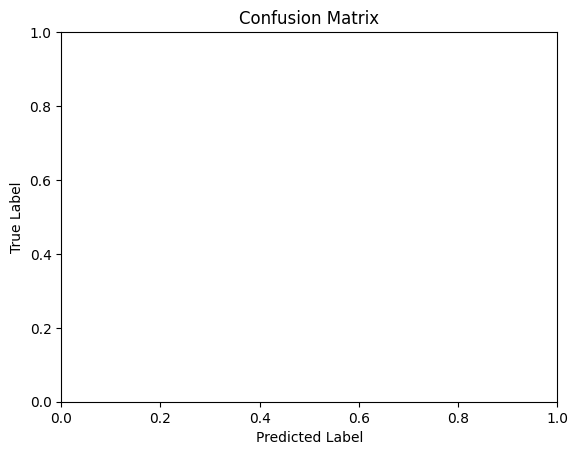

In [17]:
for i in range(5):
    print(pipeline(classifiers[i], param_grids[classifier_names[i]], x_train, x_test, y_train, y_test, scoring_param='balanced_accuracy'))

In [46]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1
clf = GradientBoostingClassifier()
cv = StratifiedKFold(4)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="balanced_accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(x_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 9


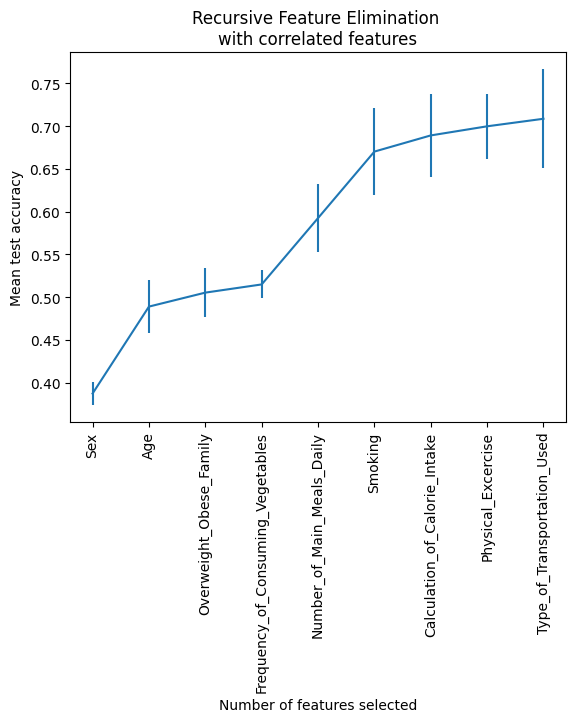

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=rfecv.feature_names_in_,
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.xticks(rotation=90)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [47]:
list(zip(rfecv.ranking_, rfecv.feature_names_in_))

[(1, 'Sex'),
 (1, 'Age'),
 (1, 'Overweight_Obese_Family'),
 (1, 'Frequency_of_Consuming_Vegetables'),
 (1, 'Number_of_Main_Meals_Daily'),
 (1, 'Smoking'),
 (1, 'Calculation_of_Calorie_Intake'),
 (1, 'Physical_Excercise'),
 (1, 'Type_of_Transportation_Used')]

In [48]:
np.logspace(-6, 6, num=5)

array([1.e-06, 1.e-03, 1.e+00, 1.e+03, 1.e+06])

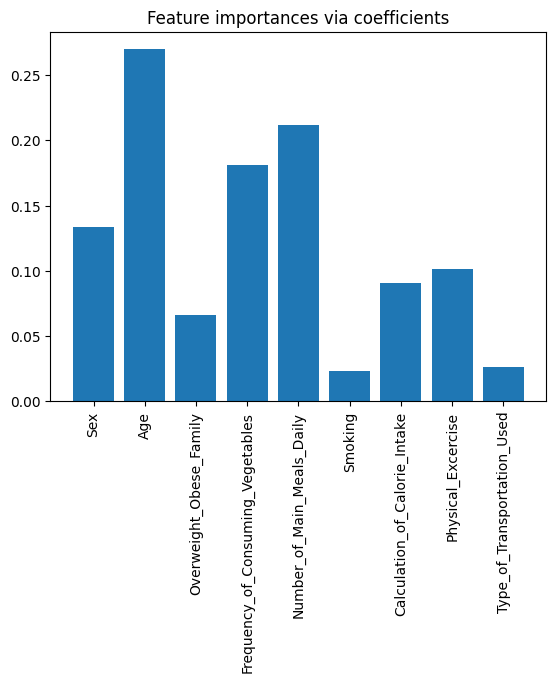

In [49]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=4)).fit(x_train, y_train)
importance = np.abs(ridge.coef_)
feature_names = np.array(x_train.columns)
plt.bar(height=importance, x=feature_names)
plt.xticks(rotation=90)
plt.title("Feature importances via coefficients")
plt.show()

In [50]:
importances = pd.Series(importance, index=x_train.columns)
importances

Sex                                  0.133842
Age                                  0.269654
Overweight_Obese_Family              0.066424
Frequency_of_Consuming_Vegetables    0.180819
Number_of_Main_Meals_Daily           0.211558
Smoking                              0.023430
Calculation_of_Calorie_Intake        0.090481
Physical_Excercise                   0.101175
Type_of_Transportation_Used          0.026161
dtype: float64

Number of drops for best score:  [0 2 0 0 2]


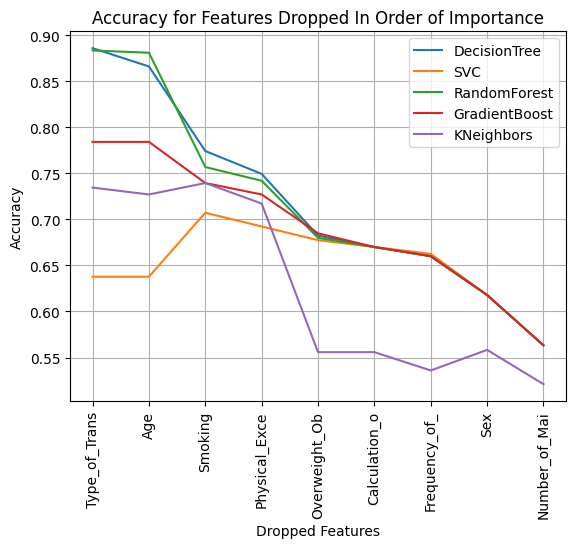

In [21]:
to_reduce = list(importances.sort_values(ascending=True).index)

dt_d_redux, svm_d_redux, rf_d_redux, gb_d_redux, knn_d_redux = [], [], [], [], []

for i in range(len(to_reduce)):
    x_tr = x_train.drop(labels=to_reduce[:i], axis=1)
    x_te = x_test.drop(labels=to_reduce[:i], axis=1)
    
    dt_d_redux.append(DecisionTreeClassifier(random_state=RANDOMSTATE).fit(x_tr, y_train).score(x_te, y_test))
    svm_d_redux.append(SVC(random_state=RANDOMSTATE).fit(x_tr, y_train).score(x_te, y_test))
    rf_d_redux.append(RandomForestClassifier(random_state=RANDOMSTATE).fit(x_tr, y_train).score(x_te, y_test))
    gb_d_redux.append(GradientBoostingClassifier(random_state=RANDOMSTATE).fit(x_tr, y_train).score(x_te, y_test))
    knn_d_redux.append(KNeighborsClassifier().fit(x_tr, y_train).score(x_te, y_test))
    
drops = np.argmax(np.array([dt_d_redux, svm_d_redux, rf_d_redux, gb_d_redux, knn_d_redux]), axis=1)
print("Number of drops for best score: ", drops)
x = [x[:13] for x in to_reduce]

fig, ax = plt.subplots()
ax.set_xlabel("Dropped Features")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy for Features Dropped In Order of Importance")
ax.plot(x, dt_d_redux, label="DecisionTree")
ax.plot(x, svm_d_redux, label="SVC")
ax.plot(x, rf_d_redux, label="RandomForest")
ax.plot(x, gb_d_redux, label="GradientBoost")
ax.plot(x, knn_d_redux, label="KNeighbors")
plt.xticks(rotation=90)
plt.grid(True)
ax.legend()
plt.show() 

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Feature Scaling
X=ob.drop(labels='Class', axis=1)
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
y=ob['Class']

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=RANDOMSTATE)

x_train = x_train.drop(['Consumption_of_Fast_Food', 
                        'Schedule_Dedicated_to_Technology',
                        'Liquid_Intake_Daily',
                        'Food_Intake_Between_Meals',
                        #'Smoking',
                        #'Type_of_Transportation_Used',
                        #'Overweight_Obese_Family',
                        'Height'], axis=1)

x_test = x_test.drop(['Consumption_of_Fast_Food', 
                      'Schedule_Dedicated_to_Technology',
                      'Liquid_Intake_Daily',
                      'Food_Intake_Between_Meals',
                      #'Smoking',
                      #'Type_of_Transportation_Used',
                      #'Overweight_Obese_Family',
                      'Height'], axis=1)


pca = PCA(n_components=2)

pca.fit(x_train)
PCA(n_components=2)

print("explained_variance_ratio_", pca.explained_variance_ratio_)

print("singular_values_", pca.singular_values_)

pca = PCA(n_components=2, svd_solver='full')
print('\n')
pca.fit(x_train)
PCA(n_components=2, svd_solver='full')

print("explained_variance_ratio_", pca.explained_variance_ratio_)

print("singular_values_", pca.singular_values_)

print('\n')
pca.fit(X)
PCA(n_components=2, svd_solver='arpack')

print("explained_variance_ratio_", pca.explained_variance_ratio_)

print("singular_values_", pca.singular_values_)

explained_variance_ratio_ [0.28989713 0.14523317]
singular_values_ [55.71588552 39.43574006]


explained_variance_ratio_ [0.28989713 0.14523317]
singular_values_ [55.71588552 39.43574006]


explained_variance_ratio_ [0.59606793 0.36523595]
singular_values_ [402.11110512 314.76391991]


In [56]:
pca.components_

array([[-0.01516593,  0.96326697,  0.23993692, -0.00697357, -0.01199328,
        -0.02967464,  0.01959419,  0.00460343, -0.00470924,  0.00165211,
        -0.00771695,  0.0462079 , -0.01709292, -0.10162208],
       [-0.03981006, -0.23717445,  0.96962453, -0.00541111,  0.0029475 ,
         0.00293978, -0.01263858, -0.00190415, -0.00686607, -0.0035864 ,
         0.00159411, -0.00472074,  0.00710364,  0.0405764 ]])

In [57]:
pca = PCA(n_components=2, svd_solver='arpack')

pca.fit(x_train)

for i in range(len(pca.components_[0])):
    print(f"{np.abs(pca.components_[0][i]):.3f} for first component {x_train.columns[i]} loadings")
    print(f"{np.abs(pca.components_[1][i]):.3f} for second component {x_train.columns[i]} loadings\n")


0.129 for first component Sex loadings
0.389 for second component Sex loadings

0.494 for first component Age loadings
0.268 for second component Age loadings

0.246 for first component Overweight_Obese_Family loadings
0.438 for second component Overweight_Obese_Family loadings

0.400 for first component Frequency_of_Consuming_Vegetables loadings
0.092 for second component Frequency_of_Consuming_Vegetables loadings

0.371 for first component Number_of_Main_Meals_Daily loadings
0.120 for second component Number_of_Main_Meals_Daily loadings

0.186 for first component Smoking loadings
0.592 for second component Smoking loadings

0.265 for first component Calculation_of_Calorie_Intake loadings
0.188 for second component Calculation_of_Calorie_Intake loadings

0.330 for first component Physical_Excercise loadings
0.019 for second component Physical_Excercise loadings

0.409 for first component Type_of_Transportation_Used loadings
0.419 for second component Type_of_Transportation_Used loadin

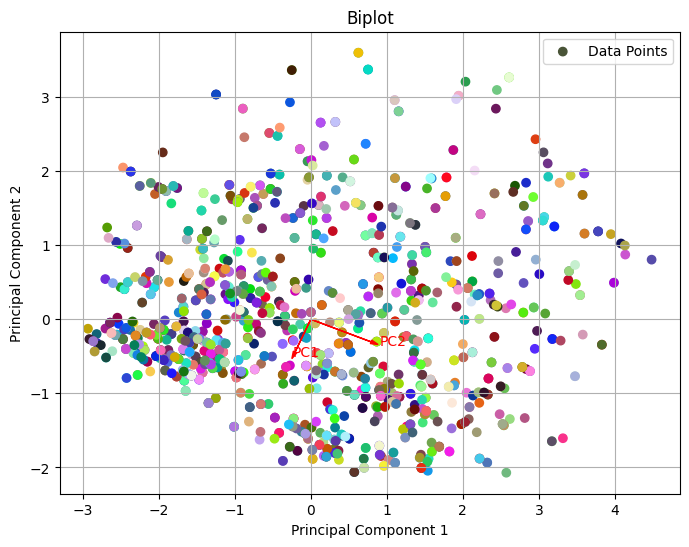

In [58]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

x_transformed = pca.fit_transform(x_train)
colors = np.random.rand(len(x_transformed), 3)

plt.figure(figsize=(8, 6))

plt.scatter(x_transformed[:, 0], x_transformed[:, 1], color=colors, label='Data Points')

for i, feature in enumerate(['PC1', 'PC2']):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
              color='red', head_width=0.05, head_length=0.1)
    plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, feature, color='red')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Biplot')
plt.grid()
plt.legend()
plt.show()